In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from utils.data.datasets import ModelParamsDataset
from utils.model.models import MLP
import utils.model.train as trainer
from utils.config import config as cfg

from tqdm.notebook import tqdm

from dotenv import dotenv_values
from pathlib import Path
import wandb
import random
import string

..\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


  0%|          | 0/300 [00:00<?, ?it/s]

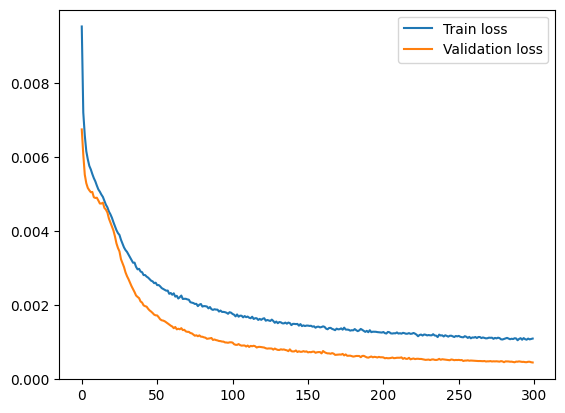

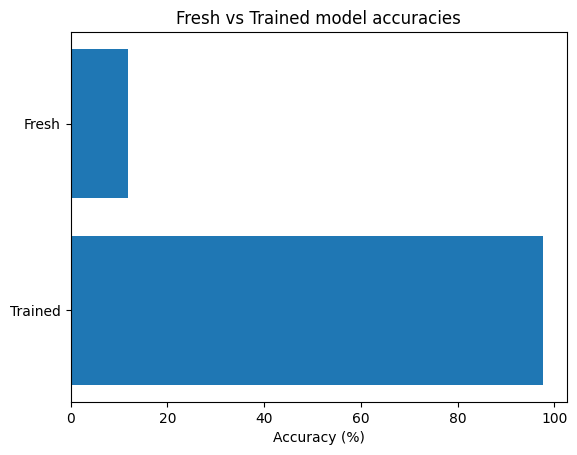

In [ ]:
config_name = "classifier_1.yaml"
config = cfg.load_config(config_name, True)
default_dirs = cfg.get_default_dirs()
models_dir = default_dirs["models_dir"]
datasets_dir = default_dirs["datasets_dir"]


name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss /= len(dataloader_train.dataset)
    train_losses.append(total_loss)
    wandb.log({"train_loss": total_loss})

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_loss /= len(dataloader_valid.dataset)
    valid_losses.append(total_loss)
    wandb.log({"valid_loss": total_loss})


plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model_fresh.to(device)
model_fresh.eval()
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct
accuracy_fresh = total_correct / len(dataloader_test.dataset) * 100

total_correct = 0
model.eval()
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataloader_test.dataset) * 100

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained.cpu().detach().numpy(), accuracy_fresh.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")


In [74]:
from utils.data.helpers import mlp_from_config
import torch.nn.utils.prune as prune
config = cfg.load_config("classifier_1.yaml")
model = mlp_from_config(config["model"])
model.load_state_dict(torch.load("../models/classifier_1.pth"))
accuracy = trainer.get_accuracy(model, dataloader_test)
print(accuracy)
module = model.fc1[0]
prune.l1_unstructured(module, name="weight", amount=0.95)
accuracy = trainer.get_accuracy(model, dataloader_test)
print(accuracy)

97.63750457763672
96.8375015258789


In [89]:
print(module.weight.shape)
weights = module.weight.cpu().detach().numpy()
usage = []
for i in range(151):
    usage.append(np.count_nonzero(weights[:, i]))

usage = np.array(usage)
print(usage)
print(usage > 10)

torch.Size([400, 151])
[ 80  87  83  85  98  92  93  97  91  97  84 100  93  97  82  88  96  95
  90  84  17   8  11  15  11  11  13   8  17  17   6   7   3   4   4   4
   9   6   6   4  18  17  19  15  16  21  10  18  15  12  16  10  13  13
  16  14  16  15  13  13   7   4   6   5   5   3   5   4   7   4   5   5
   6   3   3   2   6   3   6   4   7   8   7   5   3   6   4   7   5   7
   5   5   8   4   3   4   3   3   7   6   7   3   5   8   4   6   8   6
   3   5   3   2   2   3   2   1   4   2   5   2   6   5   9   9   8   7
   8  10   8   8   1   5   7   6   4   4   2   6   4   5  23  45  37  24
  22  35  22  29  25  26  36]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True False  True  True False False False False False False
 False False False False  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  Tru

C:\Projects\Python\master-thesis\data\eight_angles.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 75/75 [14:48<00:00, 11.84s/it]


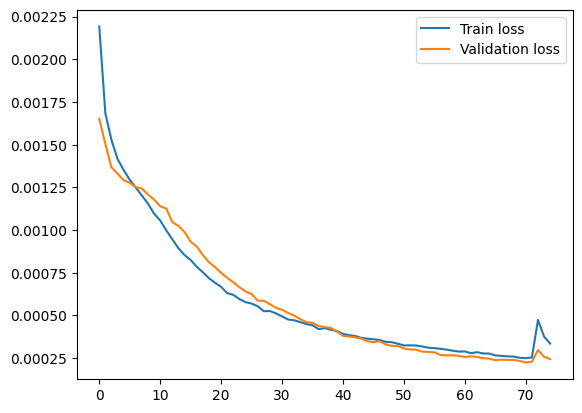

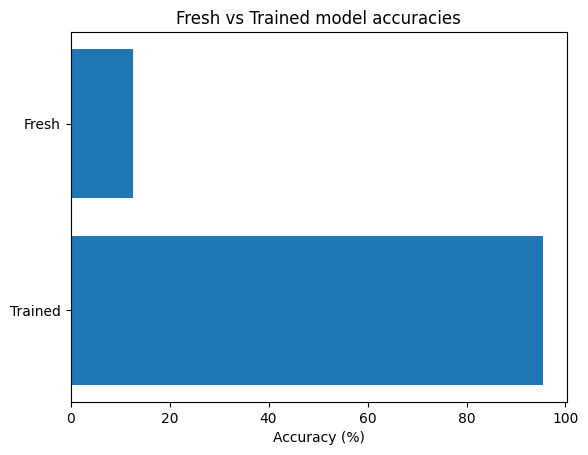

accuracy_trained,▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
valid_loss,█▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,95.45
train_loss,0.00033
valid_loss,0.00024


In [19]:
config_name = "classifier_7.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.finish()

C:\Projects\Python\master-thesis\data\eight_angles.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [10:30<00:00, 12.62s/it]


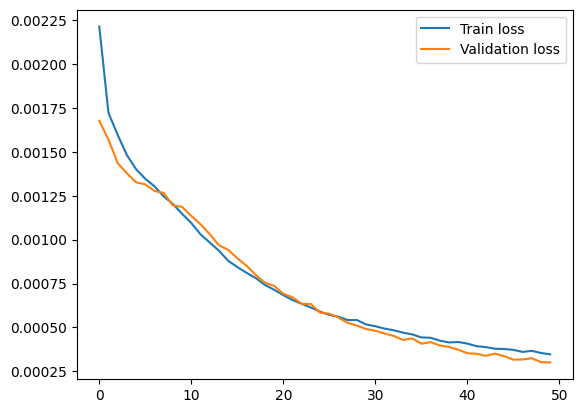

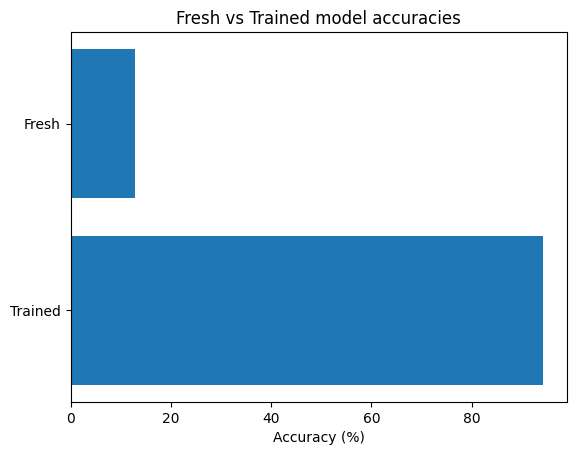

accuracy_trained,▁
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy_trained,94.2125
train_loss,0.00035
valid_loss,0.0003


In [21]:
config_name = "classifier_9.yaml"
config = cfg.load_config(config_name)
default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])


name = ''.join(random.choices(string.ascii_lowercase, k=7))
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")


# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

torch.save(model.state_dict(), models_dir / f"{name}.pth")
wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.")
wandb.finish()